In [1]:
import pandas as pd  # pandas does things with matrixes
import numpy as np  # used for sorting a matrix
import matplotlib.pyplot as plt #matplotlib is used for plotting data
import os  # used for changes of directory
import warnings

warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import seasonal_decompose

import sys
sys.path.append('../')
from utils import *

### Read the data

In [2]:
dataset = pd.read_csv("../../Data/all_stocks_5yr.csv")

# Changing the date column to the datetime format (best format to work with time series)
dataset['Date'] = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dataset['Date']]

dataset.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


In [3]:
# Assigning a mid price column with the mean of the Highest and Lowest values

dataset['Mid'] = (dataset['High'] + dataset['Low'])/2
dataset.head()

,Date,Open,High,Low,Close,Volume,Name,Mid
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM,92.165
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM,92.255
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM,92.340
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM,93.040
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM,93.945


In [4]:
# Getting rid of null columns

missing_data = pd.DataFrame(dataset.isnull().sum()).T
print(missing_data)

for index, column in enumerate(missing_data.columns):
    if missing_data.loc[0][index] != 0:
        dataset = dataset.drop(dataset.loc[dataset[column].isnull()].index)
        
missing_data = pd.DataFrame(dataset.isnull().sum()).T
print(missing_data)

   Date  Open  High  Low  Close  Volume  Name  Mid
0     0   384   208  227      0     406     0  358
   Date  Open  High  Low  Close  Volume  Name  Mid
0     0     0     0    0      0       0     0    0


In [5]:
# Let's analyze 3M stocks a bit deeper

MMM_stocks = dataset[dataset['Name'] == 'MMM']

In [6]:
# Creating a percent change column related to the closing price

percent_change_closing_price = MMM_stocks['Close'].pct_change()
percent_change_closing_price.fillna(0, inplace=True)
MMM_stocks['PC_change'] = pd.DataFrame(percent_change_closing_price)

# As we want to predict the closing price, let's add the target column as the close price shifted by 1

MMM_stocks['Target'] = MMM_stocks['Close'].shift(-1)

MMM_stocks = MMM_stocks.drop(0, axis = 0)
MMM_stocks = MMM_stocks.drop('Name', axis = 1)
MMM_stocks = MMM_stocks.drop('Date', axis = 1)

MMM_stocks.head()

,Open,High,Low,Close,Volume,Mid,PC_change,Target
1,92.36,92.50,92.01,92.30,1843476.0,92.255,-0.001082,92.54
2,92.00,92.74,91.94,92.54,1983395.0,92.340,0.002600,93.74
3,92.75,93.87,92.21,93.74,3395145.0,93.040,0.012967,94.24
4,93.93,94.30,93.59,94.24,3069513.0,93.945,0.005334,93.89
5,94.00,94.17,93.55,93.89,1640008.0,93.860,-0.003714,93.21


### We gonna first focus on univariate predictions

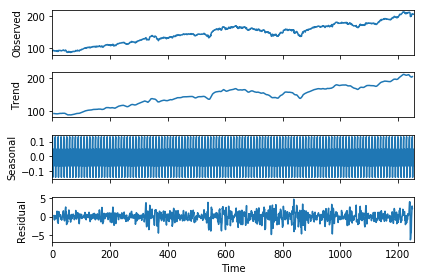

In [13]:
series = MMM_stocks['Close'].values
window_size = 10
dcmpstn = seasonal_decompose(series, model='additive', freq=window_size)
dcmpstn.plot()
plt.show()
#plt.savefig('decomp.pdf')

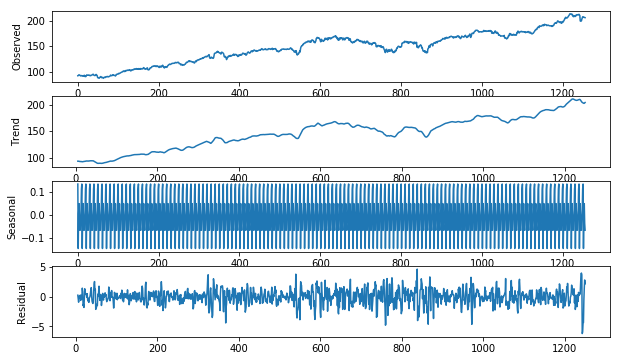

In [39]:
plt.figure(figsize=(10,6))
plt.subplot(4,1,1)
plt.plot(dcmpstn.observed)
plt.ylabel('Observed')
plt.subplot(4,1,2)
plt.plot(dcmpstn.trend)
plt.ylabel('Trend')
plt.subplot(4,1,3)
plt.plot(dcmpstn.seasonal)
plt.ylabel('Seasonal')
plt.subplot(4,1,4)
plt.plot(dcmpstn.resid)
plt.ylabel('Residual')
plt.savefig('decomp.pdf')
plt.show()


### Now, let's try to model the trend and seasonal components separately

In [8]:
# It's worth mentioning that we had lost 'window_size' samples in both ends of the series
# due to the performed transformation
trend = dcmpstn.trend[window_size:-window_size]
seasonal = dcmpstn.seasonal[window_size:-window_size]
print('Length:', len(trend))

# Therefore, we are going to limit our analysis only to the remaining values
series_c = series[window_size:-window_size]

Length: 1236


### The trend component will be predicted using a differentiated version of the series

In [40]:
# Uses the statsmodels diff method to get the first derivative
trend_diff = diff(trend)
print('Length:', len(trend_diff))
f, ax = plt.subplots()
ax.plot(trend_diff)
plt.show()

NameError: name 'trend' is not defined

In [10]:
# Train and test split
split_point = 1000

In [11]:
train_trend_orig = trend_diff[:split_point]
test_trend_orig = trend_diff[split_point:]

train_seasonal_orig = seasonal[:split_point]
test_seasonal_orig = seasonal[split_point:]

# Getting data scalers
t_scaler = StandardScaler()
train_trend = t_scaler.fit_transform(np.array(train_trend_orig).reshape(-1, 1))[:,0]
test_trend = t_scaler.transform(np.array(test_trend_orig).reshape(-1, 1))[:,0]

s_scaler = StandardScaler()
train_seasonal = s_scaler.fit_transform(np.array(train_seasonal_orig).reshape(-1, 1))[:,0]
test_seasonal = s_scaler.transform(np.array(test_seasonal_orig).reshape(-1, 1))[:,0]

In [12]:
# Preparing data for the experiment with an univariate model 
# Getting Closing Price and arranging lists for training/testing based on the sequence

# Thanks Mr. Angelo for this very useful helper :D
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)  
    return np.array(X), np.array(y)

In [13]:
# Trend component
ttr_x, ttr_y = split_sequence(train_trend, window_size)
# For the test, we add the last samples from training as the head of the list to obtain
# the same size of testing samples
aux_tts = train_trend[-(window_size + 1):].copy().tolist()
# Above, I added an extra training sample (window_size + 1) to compensate the effect of the differentiated data, 
# which looses one sample
aux_tts.extend(test_trend)
tts_x, tts_y = split_sequence(aux_tts, window_size)

# Seasonal component
str_x, str_y = split_sequence(train_seasonal, window_size)
aux_sts = train_seasonal[-window_size:].copy().tolist()
aux_sts.extend(test_seasonal)
sts_x, sts_y = split_sequence(aux_sts, window_size)

In [ ]:
tm = Sequential()
tm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(20, 1)))
tm.add(LSTM(50, activation='relu'))
tm.add(Dense(1))
tm.compile(optimizer='adam', loss='mse')


plot_model(tm, to_file='model.png', show_shapes=True, show_layer_names=True)

In [14]:
# Getting the predictions models
n_features = 1

# Trend model
# Define model
tm = Sequential()
tm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(window_size, n_features)))
tm.add(LSTM(50, activation='relu'))
tm.add(Dense(1))
tm.compile(optimizer='adam', loss='mse')

X_t = ttr_x.reshape(ttr_x.shape[0], ttr_x.shape[1], n_features)


# Fit trend model
_ = tm.fit(X_t, ttr_y, epochs=100, verbose=0)


# Seasonal model
# Define model
sm = Sequential()
sm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(window_size, n_features)))
sm.add(LSTM(50, activation='relu'))
sm.add(Dense(1))
sm.compile(optimizer='adam', loss='mse')

X_s = str_x.reshape(str_x.shape[0], str_x.shape[1], n_features)

# Fit trend model
_ = sm.fit(X_s, str_y, epochs=100, verbose=0)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


### Getting the predictions for each component

In [15]:
# Trend
trend_preds_diff = tm.predict(tts_x.reshape((len(tts_x), window_size, n_features)))[:, 0]
trend_preds_diff = t_scaler.inverse_transform(np.array(trend_preds_diff).reshape(-1, 1))[:,0]

# Now we apply the predictions of the differences (first derivative) over the lagged trend data
# Include the last point of training to enable getting predictions for the first point in testing
aux_tts_trend = [trend[split_point - 1].tolist()]
aux_tts_trend.extend(trend[split_point:-1].tolist())

# Sums the time lagged observations with the estimate of variation (first derivative)
trend_preds = []
for i in range(len(aux_tts_trend)):
    trend_preds.append(aux_tts_trend[i] + trend_preds_diff[i])
    

# Seasonal
seasonal_preds = sm.predict(sts_x.reshape((len(sts_x), window_size, n_features)))[:, 0]
seasonal_preds = s_scaler.inverse_transform(np.array(seasonal_preds).reshape(-1, 1))[:,0]

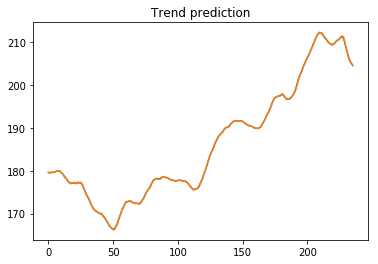

MSE: 0.010608058576237988


In [16]:
f, ax = plt.subplots()
ax.plot(trend[split_point:])
ax.plot(trend_preds)
ax.set_title('Trend prediction')
plt.show()

print('MSE:', mean_squared_error(trend[split_point:], trend_preds))

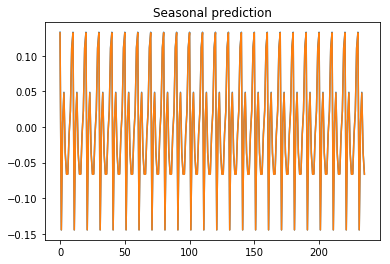

MSE: 6.443744234444605e-07


In [17]:
f, ax = plt.subplots()
ax.plot(seasonal[split_point:])
ax.plot(seasonal_preds)
ax.set_title('Seasonal prediction')
plt.show()

print('MSE:', mean_squared_error(seasonal[split_point:], seasonal_preds))

### Final predictions

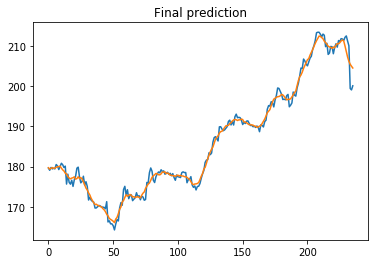

MSE: 1.6856834078095466
TU: 0.8123470231682233
POCID: 57.446808510638306


In [18]:
preds = [t + s for t, s in zip(trend_preds, seasonal_preds)]
f, ax = plt.subplots()
ax.plot(series_c[split_point:])
ax.plot(preds)
ax.set_title('Final prediction')
plt.show()

print('MSE:', mean_squared_error(series_c[split_point:], preds))
print('TU:', TU(series_c[split_point:], preds))
print('POCID:', POCID(series_c[split_point:], preds))